# Housing Price Prediction (Linear Model)  

<br>

The objective of this project, is to try and predict the sales price of a house, given a bunch of other information about the house. We'll first bring the data in, clean it up a bit, explore it, then build a few different models, and hopefully one of them is able to predict housing prices quite nicely.

The dataset is the popular Ames housing price dataset, available on Kaggle, here:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

<br>




In [1]:
# Importing modules:
# Data will be stored in pandas dataframes

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew


# Evaluating Models & Splitting Data
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Standard Linear Model
from sklearn import linear_model

# Ridge Regression Model
from sklearn.linear_model import Ridge



In [2]:
# Bringing in the data
data = pd.read_csv('train.csv')


In [3]:
# Seeing what sort of features we have in our data (data_description.txt provides a detailed description of each one)
data.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
# Looking at the first few rows of the data
n_homes = data.shape[0]
print("The number of homes, is: {}".format (n_homes))
data.head()


The number of homes, is: 1460


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<br> 

We can see, that there are **79 features** that affect homes (1460 homes total). That's a very large number to put into a general basic model, we'll see if we can find any that are insigifinicant, and then remove them. 

*The two extra features, SalePrice and Id, are not included in the count, as the former is what we're predicting, and the latter is simply an identification number, which has no bearing on the price of a home.*

## Handling Missing Data

The easiest features to remove would be the ones that are mostly empty, so let's see if any of those exist here:

In [5]:
nulls_per_feature = data.isnull().sum()

sorted_nulls = nulls_per_feature.sort_values(ascending=False)
features_miss = sorted_nulls[sorted_nulls > 0]
features_miss


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

<br>PoolQC, MiscFeature, Alley, Fence, and FirePlaceQu, are all missing values for almost half of all homes or more. We'll look at their description provided in the dataset, and analyze them a bit more carefully:


In [6]:
# Quick analysis of MiscFeature, Fence, and FirePlaceQu to help determine if they should be removed.
for i in ('MiscFeature', 'Fence', 'FireplaceQu'):
    print(data[i].value_counts(), "\n")
    

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64 

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64 

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64 



<ul>
    <li>PoolQC:<br>
        Pool Quality, varying from "No Pool" to "Excellent" (as stated in data_description.txt), knowing if a house has a pool definitely affects the price but the "PoolArea" variable already covers that. So this variable only covers quality, honestly not that important IMO, as a pool can simply be cleaned or drained, its actual size is much more important. Removing this variable.</li>
    <li>MiscFeature:<br> 
        The next cell shows this variable only contains 'Shed', for 49/1460 homes (other values are in extremely low counts, thus can be ignored), IMO sheds don't impact the house of a price that much, as their quality can vary, and a client may even want them removed, for something else. Removing. </li>
    <li>Alley:<br>
        Can be either "Gravel", "paved", or "no alley access". IMO seems irrelevant for house price, no information on condition of these alleys, how busy they are, graffiti, or anything else. Removing. </li>
    <li>Fence:<br>
        Varies from "No fence" to "Good Privacy", seems too insignificant to include, only Good Privacy would likely impact the cost a bit, and it's only present for 59/1460 homes. Removing. </li>
    <li>FirePlaceQu: <br>
        Mainly covers whether fireplaces are built of masonry or not, compared to things like LotSize, and OverallQu, this is also too insigificant for a general model. Removing. </li>
</ul>  

<br><br>
Now, what about the rest of these features? We can't build any good models until all empty values are taken care of, so we could either drop them as well, or substitute the NA values. 

Well luckily, The **Garage features** all group together nicely, and all seem to have missing values for the same 81 houses (I assume these 81 houses have no garages, hence 81 NA's), so we can remove all of them, and simply use "GarageArea" (which IMO affects house price the most, out of the garage variables, and it also covers the 81 houses that have no garage, by being 0).

There's also the **Bsmt features** which all also group together, missing 37-38 values. From their descriptions, the TotalBsmtSF feature (size of the basement) would be far more important than this group (making a basement physically larger, instead of just renovating it, would be far more expensive), so we'll remove these variables.

**LotFrontage** (the length of the lot facing the street), IMO would be a noticable factor in the house price, thus it will be kept, and missing values will be replaced with the mean.

**Electrical**, which is just missing one value, we can delete that single row.

Finally, **MasVnr features** seem unimportant compared to the more main variables: LotArea, OverallQual(of the entire property), YearBuilt, TotalRmsAbveGrd, thus they will be removed (these features just talk about the masrony type of the veneer)

### Summary of Missing Data:
We will be removing all features, except for Electrical (deleting single missing row), and LotFrontage (replacing missing values with mean)

In [7]:
# Removing features, inplace=True, so running this cell again will produce an error, the features will have already been dropped
for i in features_miss.index:
    if i not in ('Electrical', 'LotFrontage'):
        data.drop(columns=i, inplace=True)
        
# Removing the single row that's missing Electrical
indx_row = data['Electrical'].isnull().idxmax()
data = data.drop(index=indx_row)

# Replacing all the missing values in LotFrontage, with the mean
mean = data['LotFrontage'].mean()
data['LotFrontage'] = data['LotFrontage'].fillna(mean)


In [8]:
# Checking to see if there are any missing values still in our dataset
print("The number of missing values in our entire dataset is... {}".format(data.isnull().sum().sum()))
data

The number of missing values in our entire dataset is... 0


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


<br>

## Multi-collinearity

So, we've taken care of the easy to remove features, basically the ones that had missing values. Now, we can try and get rid of features that have multi-collinearity. Just to clarify, multi-collinearity is basically features that are highly positively correlated to each other. It's a good idea to remove these for our models, because if two features are highly positively correlated, let's say X and Y, then as we vary/change X in isolation to see how our target feature (SalePrice in this case), varies/changes, unfortunately Y will also be varying/changing simultaneously, thus making it very difficult to know if the target variable "SalePrice", is changing because of X, or Y. (There may be certain reasons to keep multi-collinearity features, like say if the two features actually cover very different important things/aspects, and just so happen to coincidentally correlate quite strongly just in our data, but usually this isn't the case)

To figure out which features correlate very positively strongly with each other, we can use a correlation matrix, (with seaborns corr_matrix, we're looking for white tiles basically). 

Additionally, if our training/testing datasets were extremely larger (millions more houses involved), and time was quite limited when building the basic prediction models, I would also drop the features that had the very lowest correlations to SalePrice (if there were no other outstanding reason to keep them), for optimisation/time-saving. But since our datasets are really small here, and the models aren't highly complex, I'll keep them.  
<br>


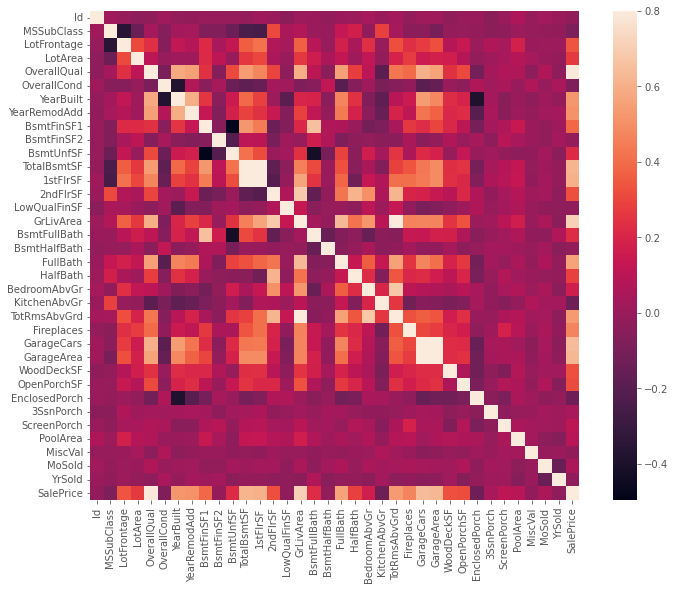

In [9]:
# Correlation matrix of numeric features, to help eliminiate irrelevant features
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);


<br>
There only seems to be 4 invididual white tiles (can ignore the top side, it's duplicate information), which means we only have a few features with multi-collinearity, specifically: 

<ul>
    <li>(GarageArea, GarageCars)</li>
    <li>(TotalBsmtSF, 1stFlrSF)</li>
    <li>(GrLivArea, TotRmsAbvGrd)</li>
    <li>(SalePrice, OverallQual), but we will ignore this one, as SalePrice is the target feature, so we're obviously not removing either.</li>
</ul>

GarageArea/GarageCars multi-collinearity makes sense, GarageCars is basically just determined by GarageArea (bigger the Garage, the more cars you can fit in), so we'll just use GarageArea, as it far more accurately portrays a Garage, than "GarageCars".

TotalBsmtSF/1stFlrSF makes sense as well, normally a basement when built, won't exceed the size of the floor above, and I imagine wouldn't usually be too much smaller than either, since the foundations will have to be at least larger than the floor above. Unfortunately however, we cannot remove either, TotalBsmtSF is being used in place of all the other Bsmt features we dropped earlier in missing data, no other remaining Bsmt feature provides as good an idea of a basement as this feature, nor tracks as accurately, whether a basement exists for a home or not. 

GRLivArea/TotRmsAbvGrd makes sense, the larger the homes interior, the more rooms that could be fit inside, so TotRmsAbvGrd can just be looked as a function of GrLivArea, thus we'll just use GrLivArea, as it far more accurately gauges the overall interior size of a home (a home with lots of rooms may not necessarily be large, all rooms may simply be quite small).

So, we'll drop GarageCars, and TotRmsAbvGrd.

We'll also finally drop Id, since it's of no use (doesn't offer any insight into the actual homes)


In [10]:
# Dropping GarageCars & TotRmsAbvGrd if this celll is run more than once, an error will occur, columns have already been dropped
data.drop(columns=['GarageCars', 'TotRmsAbvGrd', 'Id'], inplace=True)


### Exploring the data a bit

Now, just for the sake of exploring the raw data, better understanding it, and making sure we're not missing anything, we'll just look at the correlation matrix from above, again. As we can see from the bottom row, there are quite a few features with a weak correlation to SalePrice, such as Id (of course), OverallCond, BsmtFinSF2, LowQualFinSF, etc (basically the darkish pink ones). On the other hand, OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, GargeCars, and a few others (brightest ones) have a very strong correlation with SalePrice, thus implying they're the most important. This seems to make sense, the raw data doesn't seem like it has any big anomalous clumps or anything. 

Let's take the top 20 features, and see what their correlation to SalePrice is (just to better understand the data, not dropping weakest correlation features here).

In [11]:
# Top 20 most correlated features (not including categorical), to SalePrice
corr_mat = data.corr()
corr_df = corr_mat.nlargest(20, 'SalePrice')
mst_corr_f = corr_df['SalePrice']
mst_corr_f


SalePrice       1.000000
OverallQual     0.791069
GrLivArea       0.708618
GarageArea      0.623423
TotalBsmtSF     0.613905
1stFlrSF        0.605968
FullBath        0.560881
YearBuilt       0.523273
YearRemodAdd    0.507430
Fireplaces      0.466968
BsmtFinSF1      0.386436
LotFrontage     0.334922
WoodDeckSF      0.324422
2ndFlrSF        0.319464
OpenPorchSF     0.315831
HalfBath        0.284400
LotArea         0.263837
BsmtFullBath    0.227082
BsmtUnfSF       0.214446
BedroomAbvGr    0.168235
Name: SalePrice, dtype: float64

A lot of these make sense, the OverallQual (of the entire house) should have a big impact on its SalePrice, same with GrLivArea (total above ground living area), GarageCars, GarageArea, TotalBsmtSF, etc.

I won't drop the lowest correlation features (like LotArea/BsmtFullBath, or even the ones that didn't make it on this top 20 list), as again, the dataset is quite small, and thus when running/training/testing models, it won't take too long.

Now, let's move onto outliers, which can definitely throw some models off a fair bit.


## Outliers

First, let's see what the distribution is like for our target feature, as well as some summary statistics about it.


count      1459.000000
mean     180930.394791
std       79468.964025
min       34900.000000
25%      129950.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


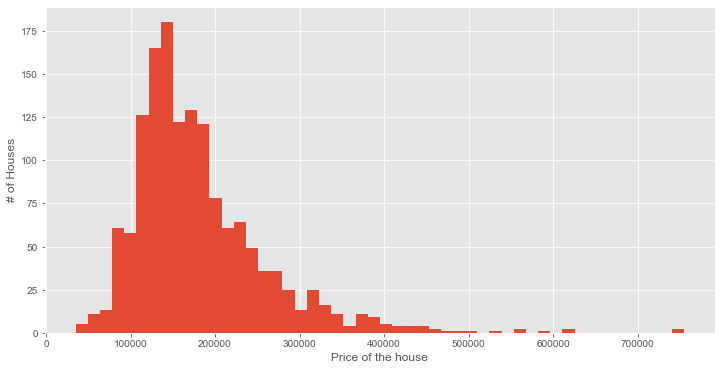

In [12]:
# Summary statistics
SalePrices = data['SalePrice']
print(SalePrices.describe())

# Distribution (via histogram)
plt.figure(figsize=(12,6))
plt.hist(SalePrices, bins=50)
plt.xlabel("Price of the house")
plt.ylabel("# of Houses")
sns.set_theme(style="darkgrid")

It looks like there might be a few outliers, the max is 755,000, whereas the mean is only 180,930. Let's try a boxplot. Additionally, the target variable isn't normally distributed, it definitely is positively/right skewed.

The boxplot has 61 outliers.


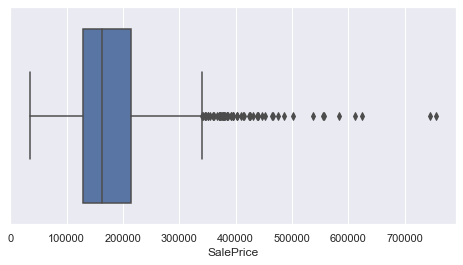

In [13]:
# Boxplot of target variable
plt.figure(figsize = (8, 4))
sns.set_theme(style="darkgrid")
sns.boxplot(x=data['SalePrice']);

# Count number of outliers
from matplotlib.cbook import boxplot_stats
outliers = boxplot_stats(data['SalePrice']).pop(0)['fliers']
print("The boxplot has {} outliers.".format(len(outliers)))

So we have 61 outliers, which is about 4% of our entire training dataset, 2 of them especially are well beyond every other home by over 100,000 (the two above 700,000). I'll throw down some scatterplots of the most important features, to help determine if these outliers, especially the two most extreme ones, behave like all the other homes (and are just really, REALLY, nice homes,) or if we potentially have some erroneous SalePrice data in our dataset.

<br>


In [14]:
# Declaring most important features (IMO, which in general seem to be the highest correlated ones in mst_corr_f, 
top10 = mst_corr_f[:10].index
top10


Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'],
      dtype='object')

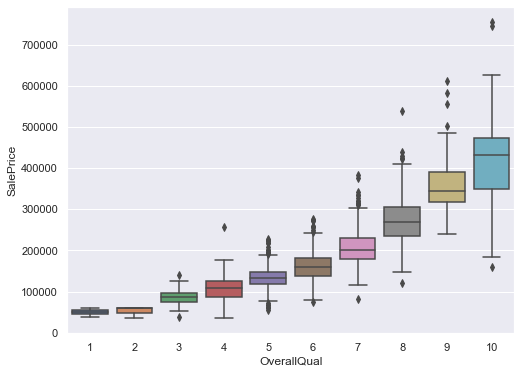

In [15]:
# Plot of OverallQual vs SalePrice (OverallQual only takes on 10 different values, thus comparative boxplots)
plt.figure(figsize = (8, 6))
sns.boxplot(x=data[top10[1]], y=data[top10[0]]);
sns.set_theme(style="whitegrid")


We can immediately see our two 700,000+ houses have an OverallQual of 10, so it doesn't seem like these two instances are erroneous, lets continue.

<br>

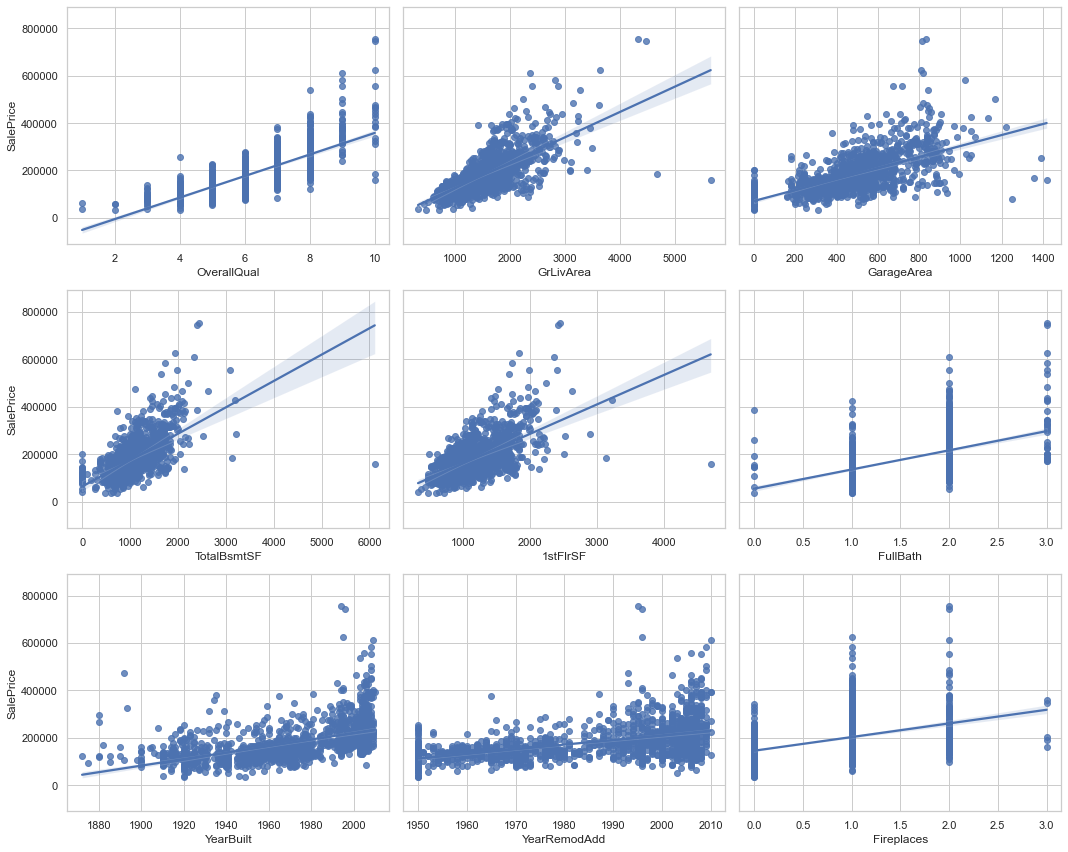

In [16]:
# Plotting SalePrice vs the (IMO) most important features (OverallQual included, to get a nice 3x3 gridplot)
nplot = len(top10) - 1
ncol = 3
nrow = nplot // ncol + bool(nplot % ncol)

fig, axs = plt.subplots(nrow, ncol, figsize=(15,12), sharey=True)
for ax, xvar in zip(axs.flat, top10[1:]):
    sns.regplot(data=data, x=xvar, y="SalePrice", ax=ax)

# Removing Duplicate SalePrice label for each row
plt.setp(axs[:, 1:], ylabel="")

# Plotting
fig.tight_layout()

<br>

In all 9 of our scatterplots, we can see our two initially spotted outlier homes (above 700,000), and it looks like these homes aren't a result of erroneously edited data or anything like that. They both have an OverallQual of 10, a very large GrLivArea (more than all other 1457 homes, with 2 exceptions), the highest number of FullBath, a very high TotalBsmtSF, 1stFlrSF, etc etc. They were even built fairly recently as shown in the YearBuilt graph (probably around 1995, so quite modern).

Thus, these 2 outliers will not be removed, because they aren't a result of erroneous data or anything like that, but are simply incredible homes compared to the rest (and thus should have much higher SalePrice values than the rest).

### Sneaky anomalous home

However, interestingly there appears to be a single home with a TotalBsmtSF over 6000, that's well beyond any other home, and is likely the same home that has by far the largest 1stFlrSF as well (given the high positive correlation between these two features, and very similar graphs), which means it's likely the home with the largest GrLivArea too. Yet it has a very low SalePrice, and thus shows up as an extreme outlier in a few of these graphs.

We'll select this particular outlier home, and look at it in further detail, to see if it should be removed.

In [17]:
# Potentially erroneous home, we'll look at additional features, not just most important ones, incase we're missing something.
info = []
for i in top10:
    info.append(i)
info.extend(['Utilities', 'BldgType', 'HouseStyle', 'OverallCond'])

indx = data['TotalBsmtSF'].idxmax()
data.iloc[indx][info]


SalePrice       160000
OverallQual         10
GrLivArea         5642
GarageArea        1418
TotalBsmtSF       6110
1stFlrSF          4692
FullBath             2
YearBuilt         2008
YearRemodAdd      2008
Fireplaces           3
Utilities       AllPub
BldgType          1Fam
HouseStyle      2Story
OverallCond          5
Name: 1298, dtype: object

Here we have confirmation this is the home with the largest TotalBSmtSF, 1stFlrSF, GrLivArea, and even GarageArea (only one above 1400). Additionally, it  even has an OverallQual of 10, despite having a SalePrice of 160,000 (which means its the bottom-most outlier in OverallQual boxplot graph, in the 10 section). Also has 3 Fireplaces, built in 2008, 2 story, fully built.

This must be an anomalous home, with either a mistake entered into the SalePrice, or it has been extremely undervalued during assessment. Thus it will be marked as a genuine outlier (doesn't behave like all the other homes, should be far higher in price, there's only 1 other home with an OverallQual of 10 that's close to it, the rest are at least 70,000-ish higher in price, and are all a lot smaller in size)

Thus this home will be deleted, as it has the potential to affect the models we will soon build.

*Note: There is one other outlier in GrLivArea with a value larger than most, but it seems to have a much smaller 1stFloorSF (there are no homes in this database with more than 2.5 floors, so the huge GrLivArea can't be due to many floors), that is  more in line with the rest, thus it won't be investigated for this brief regression project.*



In [18]:
# Removing single extreme outlier row, running this more than once triggers an error, as the row has already been removed.
data = data.drop(indx)

# Checking to see if its gone (had a TotalBsmtSF > 6000)
if data['TotalBsmtSF'].max() > 6000:
    print("Outlier remains")
else:
    print("Outlier is gone.\n")


Outlier is gone.



## Normalisation

Now that we've taken care of missing values, multi-collinearity, and obvious outliers, before we convert categorical features and model, we want to take care of the fact that SalePrice isn't normalised (remember it was positively/right skewed), which would negatively affect the models we'll be using. So we'll have to normalise it. 

For this basic project, we'll just take the log of SalePrice, which should hopefully be good enough.

Skew of current distribution is: 1.88


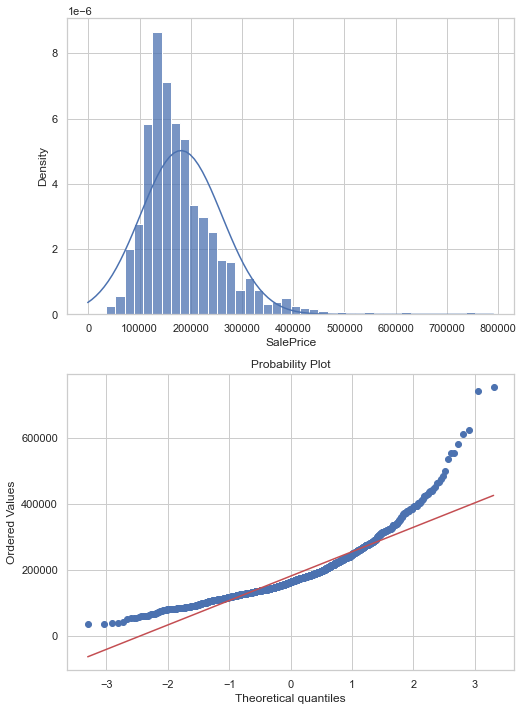

In [19]:
# Comparison between current SalePrice distribution, and its distribution if it was perfectly normal:

# Creating subplots
fig, axes = plt.subplots(2,1,figsize=(8,12))

# Seaborn histogram of current SalePrices
sp = data['SalePrice']
ax = sns.histplot(sp, bins=40, stat='density', ax=axes[0])

# Normal distribution/curve
mean, std = stats.norm.fit(sp)
sp_trans = np.linspace(*ax.get_xlim(),100)
ax.plot(sp_trans, stats.norm.pdf(sp_trans, mean, std));

# Deviation between current SalePrice values, and SalePrice values if they were perfectly normally distributed:
stats.probplot(sp, plot=plt);

# Skew value
print("Skew of current distribution is: {:.2f}".format(data['SalePrice'].skew()))


Skew of transformed distribution is: 0.12


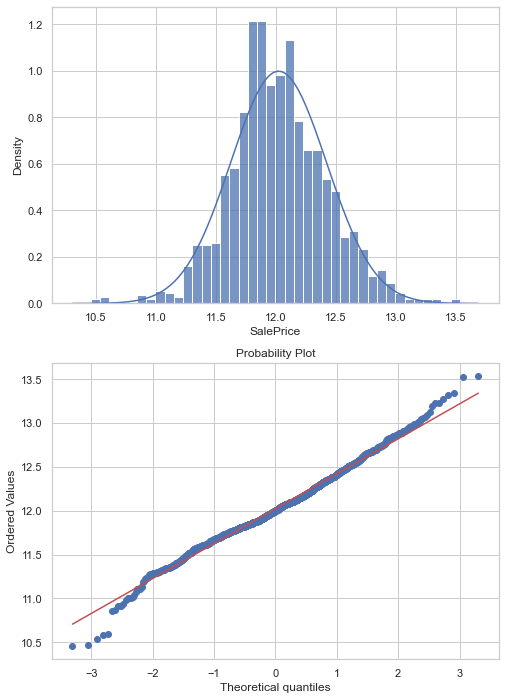

In [20]:
# Converting All SalePrices into Log of Sale Prices
data['SalePrice'] = np.log(data['SalePrice'])
sp = data['SalePrice']

# Creating subplots
fig, axes = plt.subplots(2,1,figsize=(8,12))

# New histogram
sp = data['SalePrice']
ax = sns.histplot(sp, bins=40, stat='density', ax=axes[0])

# Normal distribution/curve
mean, std = stats.norm.fit(sp)
sp_trans = np.linspace(*ax.get_xlim(),100)
ax.plot(sp_trans, stats.norm.pdf(sp_trans, mean, std));

# Deviation between transformed values, and normal values
stats.probplot(sp, plot=plt);

# Skew value
print("Skew of transformed distribution is: {:.2f}".format(data['SalePrice'].skew()))

<br>

There we go! As we can see, the SalePrice target feature has now been quite close to perfectly normalised. We won't perform feature scaling & engineering (beyond what we've already done), on any of the other features, just to keep the project more brief. We'll instead move onto the categorical features.

*Note: In a larger project, further feature scaling & engineering should definitely be considered, as it makes gradient descent convergence smoother for machine learning models, as well as many other benefits depending on which models are used. This project however, is quite brief, with a small dataset.*


<br>

## Categorical Features

 We can either drop or encode them, as the models we'll be using can't handle categorical features.

Thankfully, Pandas offers a great way to encode categorical features, in the form of the get_dummies function, which uses the One-Hot encoding technique, which works well on categorical features, so long as none of them can take on MANY different values. Scrolling through the data_description_txt, reveals that Neighbourhood, is the categorical features with the most values, around 20-30 or so, the rest are under this, so One-Hot encoding should be at least adequate for this small project. 


In [21]:
#Encoding categorical features via the One-Hot technique
print("Number of 'features', before encoding: {}".format(data.shape[1]))
data = pd.get_dummies(data)
print("Number of 'features', AFTER encoding: {}".format(data.shape[1]))

Number of 'features', before encoding: 61
Number of 'features', AFTER encoding: 219


## Modelling

We're finally ready to build some basic models with our data

The first model we'll use, is simple multivariable linear regression, nothing fancy.

The second model we'll use, is Ridge Regression. This is a variant of multivariable linear regression, that's designed to avoid overfitting, when multi-collinearity is present. I haven't THOROUGHLY addressed multi-collinearity (only one correlation matrix was made, categorical variables were not included), so there still may be a bunch of features that are highly linearly correlated, which means if we just use multivariable linear regression, that model may be overfit. Thus, Ridge Regression.

*Note: Maybe we should just try 1 decision tree for regression, THEN do a random forest. Something to think about / come back to*

The third model we'll use is something quite different, called a random forest, which is just made up of lots of decision trees. (fundamentally different to linear/ridge regression, it doesn't use gradient descent to improve itself, unlike linear/ridge regression).

We'll be splitting our data up into two sets, training and testing, 80-20 (so 20% of all homes go into testing set)


In [50]:
# Splitting the data
x = data.drop(columns='SalePrice')
y = data['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print("Number of homes in training set: {}".format(x_train.shape[0]))
print("Number of homes in test set: {}".format(x_test.shape[0]))


Number of homes in training set: 1166
Number of homes in test set: 292


<br>

### Linear Regression Model

In [51]:
# Building Linear Regression Model
LR = linear_model.LinearRegression() 
LR.fit(x_train, y_train)

# Predicting using our test set
LR_predict = LR.predict(x_test)


So, now that we've built our linear regression model, let's see how well it did. Before we look at standard things like root mean squared error (rmse), we'll look at the individual differences, between prediction values, and the actual correct answers. 

##### Evaluating LR Model

In [52]:
# Display up to 500 rows, so we can see all the data, then reset row display count
pd.set_option('display.max_rows', 500)
LR_diff = LR_predict - y_test
print("Linear_Predicted - Actual, log form")
LR_diff.round(4)


Linear_Predicted - Actual, log form


1361    0.0490
720    -0.0402
627     0.1213
144     0.0367
930     0.0428
1011   -0.0073
511    -0.0138
450     0.0444
1065   -0.2004
102    -0.1106
542    -0.0916
1103   -0.0420
477     0.0679
1440    0.0815
1197   -0.0248
793     0.0073
314    -0.0823
505    -0.0657
134    -0.0269
686     0.0074
568    -0.1183
49      0.0746
514     0.0437
463    -0.0362
761     0.0729
1175    0.1347
963     0.0985
704    -0.0050
135     0.0510
1240   -0.0908
254    -0.0197
1184    0.1082
1400    0.0053
959     0.1128
1160   -0.0315
978    -0.0892
649    -0.1198
257     0.0596
1245    0.1570
191     0.0353
1314   -0.0132
1238   -0.0619
642     0.1210
1007   -0.0405
117    -0.0664
226    -0.1088
363    -0.0388
513     0.0107
1152   -0.2074
442    -0.0988
347     0.1504
906     0.0099
339    -0.0621
878    -0.0283
1348    0.0326
1012   -0.0110
527     0.0034
1219    0.0597
188    -0.0588
107    -0.3688
655     0.0964
739     0.0107
807    -0.1578
175    -0.1991
526    -0.0427
691     0.1000
475     0.

##### Issues/anomalies detected

As we can see, the difference between predicted and actual correct answer, in almost all 292 cases, seems to be fairly small (between 0 and 1, because both predicted and actual are currently in log form, hence the very small differences). But, very interestingly, there are about 3-5 instances, where the difference is a tremendously large value (above 1000)

This means that in 3-5 cases, our model outputted extremely large SalePrices, let's check this by taking a look at all prediction values, in their regular form (undoing the log), 

In [53]:
# Undoing log transformation applied to SalePrices earlier, then showing all prediction values of Linear Regression model
LR_predict = np.exp(LR_predict)
np.around(LR_predict, 0)

array([273064., 264176., 172739., 129673., 209783.,  99274., 199889.,
       114990., 268434., 106506., 194575., 152938., 406689., 207219.,
       140472., 226656., 163941., 116587., 175231., 229576., 281283.,
       136838., 100811., 181992., 107564., 326092., 263736., 211948.,
       183109., 205371., 142175., 208029., 120634., 173513., 141475.,
       100608.,  74961., 233506., 208253., 190604., 117434., 133950.,
       389384.,  84505., 145039., 260116., 113506., 135443., 186917.,
       147572., 183066., 257546., 145669., 143864., 222116., 163194.,
       447768.,  97127., 144574.,  79533.,  96910., 192048., 190882.,
       199128., 126485., 834424., 139718., 144361.,  90542., 118289.,
       276876., 105508., 137726., 135151., 120314., 106986., 225630.,
       182031., 139883., 137545., 125353.,  92399., 254218., 124061.,
       149752., 111836., 111884., 196594., 211625., 268154., 299795.,
       119721., 340199., 126462., 109942., 130428., 273055., 331695.,
       188592., 1233

##### LR Model poor, likely due to multi-collinearity in categorical features
<br>

As we can see, in almost all 292 SalePrice predictions, our model outputs reasonable values, between about 100,000 and 600,000, that's good news. But there are about 3-5 cases, where the model predicted values so large, python refers to them as inf, thus they must be at least 10^256, and there are a few cases where the model predicted SalePrices of 0.

I very strongly suspect that these few anomalies, are due to multi-collinearity amongst our categorical features, since our correlation matrix earlier didn't include them. (so a lot of our categorical features are potentially highly linearly correlated to each other, and/or the rest of the features in our dataset). 

Fortunately, Ridge Regression is literally designed for situations where we have lots of features that are highly linearly correlated to each other. So, it should solve this problem, let's find out:

<br><br>

### Ridge Regression

In [54]:
# Building Ridge Regression Model
RR = Ridge(alpha=1.0)
RR.fit(x_train, y_train)

# Predicting using test set
RR_predict = RR.predict(x_test)


##### Evaluating Ridge Regression

In [55]:
# Display up to 500 rows, so we can see all the data, then reset row display count
pd.set_option('display.max_rows', 500)
RR_diff = RR_predict - y_test
print("Ridge_Predicted - Actual, log form")
RR_diff.round(4)


Ridge_Predicted - Actual, log form


1361    0.0483
720    -0.0238
627     0.1306
144     0.0670
930     0.0464
1011    0.0112
511    -0.0142
450     0.0464
1065   -0.1973
102    -0.1182
542    -0.0923
1103   -0.0316
477     0.0654
1440    0.0865
1197   -0.0068
793    -0.0204
314    -0.0775
505    -0.0751
134    -0.0301
686     0.0089
568    -0.1207
49      0.0730
514     0.0519
463    -0.0353
761     0.0670
1175    0.1307
963     0.1082
704    -0.0015
135     0.0680
1240   -0.0908
254    -0.0202
1184    0.0809
1400    0.0189
959     0.1160
1160   -0.0506
978    -0.1091
649    -0.1035
257     0.0547
1245    0.1534
191     0.0501
1314   -0.0197
1238   -0.0585
642     0.1241
1007   -0.0278
117    -0.0719
226    -0.1165
363    -0.0241
513     0.0069
1152   -0.1964
442    -0.0884
347     0.1449
906     0.0165
339    -0.0679
878    -0.0297
1348    0.0599
1012   -0.0068
527    -0.0135
1219    0.0382
188    -0.0776
107    -0.2856
655     0.0851
739     0.0138
807    -0.1567
175    -0.1905
526    -0.0435
691     0.0890
475     0.

<br>

ALL of the differences for all 292 test cases look quite small, this is good news, it SEEMS like the anomaly issue has been addressed. Let's convert predicted and actual SalePrice values back to regular form (from log form), and see what the differences there are, to get an initial feel for how well Ridge did. 

<br>

In [56]:
# Converting predicted and test values back into regular form, from log form, then seeing difference
RR_predict_reg = np.exp(RR_predict)
y_test_reg = np.exp(y_test)
RR_diff_reg = RR_predict_reg - y_test_reg
print("Ridge_Predicted - Actual, regular form")
RR_diff_reg.round()



Ridge_Predicted - Actual, regular form


1361    12869.0
720     -6480.0
627     21345.0
144      8658.0
930      9537.0
1011     1129.0
511     -2857.0
450      5224.0
1065   -58718.0
102    -13260.0
542    -18799.0
1103    -4954.0
477     25697.0
1440    17252.0
1197     -971.0
793     -4545.0
314    -13275.0
505     -9003.0
134     -5342.0
686      2027.0
568    -35999.0
49       9621.0
514      5138.0
463     -6544.0
761      6935.0
1175    39792.0
963     27322.0
704      -312.0
135     12251.0
1240   -19513.0
254     -2905.0
1184    15738.0
1400     2290.0
959     19058.0
1160    -7203.0
978    -11369.0
649     -8311.0
257     12365.0
1245    29506.0
191      9447.0
1314    -2317.0
1238    -8096.0
642     45597.0
1007    -2412.0
117    -10760.0
226    -31884.0
363     -2809.0
513       925.0
1152   -41010.0
442    -13788.0
347     24551.0
906      4248.0
339    -10178.0
878     -4325.0
1348    13264.0
1012    -1117.0
527     -5966.0
1219     3564.0
188    -11442.0
107    -28566.0
655      7812.0
739      2639.0
807    -

These difference values seem quite good (as in small), the anomaly problem seems gone completely, further reinforcing my suspicion it was due to multi-collinearity amongst categorical features. We can put look at the RMSE, as well as Mean Absolute Error, and put these differences in a histogram, to better evaluate Ridge.

The RMSE of Ridge is: 18828
The MAE of Ridge is: 13182




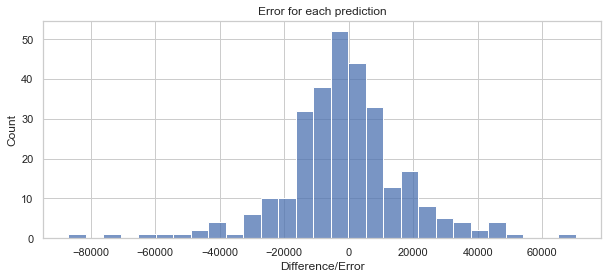

In [57]:
# RMSE and MAE
mae = mean_absolute_error(y_test_reg, RR_predict_reg)
mse = mean_squared_error(y_test_reg, RR_predict_reg)
rmse = np.sqrt(mse)
print("The RMSE of Ridge is: {:.0f}".format(rmse))
print("The MAE of Ridge is: {:.0f}".format(mae))
print("\n")

# Histogram of differences (predicted - actual)
plt.figure(figsize=(10,4))
plt.xlabel("Difference/Error")
plt.title("Error for each prediction")
sns.histplot(RR_diff_reg);

##### Ridge seems quite good
<br>

**So, for the 292 homes/predictions, Ridge was off on average by about \\$13,182 (or \\$18,828 if using RMSE, which is more sensitive to outliers).**

This seems fairly decent, since earlier we found that the **median house price** in our entire dataset was **\\$163,000,** so the **RMSE is only about 12\% of that, MAE is 8\%.**

So if we used this model to predict future houses (preferably similiar to the ones in the training data, not 5 million dollar plus homes, that are quite rare, which our model hasn't trained for), on average, the model would technically only be off by about 8\% / 12\%, or \\$13,000 / \\$19,000, (depending on how much you care about outliers, if you don't care about them as much, MAE as it's the basic average, but if you care about outliers a lot, RMSE as it emphasizes them due to the squaring).

Thus, overall, realistically speaking, Ridge seems quite good IMO, and we now have our model, that can predict the prices of houses fairly well! 

(At least for a few day project)

Thank you!

Fin.